In [1]:
global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file

In [1]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


In [2]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')


In [6]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

spaces = snapshot.Query.spaces(
    first=5000,
    orderby = 'name',
    orderdirection = 'asc'
)
print(spaces)

spaces_list = sg.query_df([
    spaces.name
])
spaces_list

In [8]:
spacename = input('spacename plz?')
# based on their url, for example "curve.eth" for  https://snapshot.org/#/curve.eth
print  (spacename)

olympusdao.eth


In [9]:
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=1000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)


In [10]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.created,
    proposals.id,
    proposals.body,
    proposals.start,
    proposals.end,
    proposals.votes
])

proposals_snapshots.head(10)

,proposals_title,proposals_created,proposals_id,proposals_body,proposals_start,proposals_end,proposals_votes
0,OIP-136: Cross-chain native OHM as bonus proje...,1680108558,0xe8117f18e79acf2e15f7254308c8d1c1138840f5c907...,## Summary\n\nDesignate the “Cross-chain Nativ...,1680108526,1680367726,74
1,TAP-22 - Treasury Segmentation,1680108259,0xebd3cf4c019ddf8eb637c816379c8b464fc20ee78284...,## Summary:\nRestructure Olympus DAO Multisig ...,1680108233,1680367433,63
2,OIP-135: Olympus Grants Program 1-Year Review ...,1679402793,0x246ccd5ab718a160f03e3dbbd1280ebb5389d3637946...,Summary\n\nThis OIP seeks authority from the c...,1679402748,1679686380,67
3,AP-23 - Liquidity Incentives for Aura / Balanc...,1679325165,0xde251686e7f312a5e524ba45f4115a887e31ab6a3cb5...,Summary:\nEstablish an ongoing budget for voti...,1679325106,1679500800,50
4,OIP 134: Hypernative as a security and risk de...,1679244244,0x58a7bc957b83e4a6424cb72d80bf3c3b0bd8025d0da1...,### Summary\n\nBelow is a preliminary list of ...,1679244167,1679503367,68
5,OIP-133: Staking Rate Strategy,1678428395,0x0fbdc3e8adbda28970646743492623e92e3a7c2336d4...,# Motivation - “how do we make 80% of OHM prod...,1678428364,1678687564,76
6,OIP-132: wstETH/OHM Boosted Liquidity Engine,1678427799,0x991058cca07d1e6f361217927a99951d200826e2ee57...,# Summary\nLaunch a Boosted Liquidity Engine f...,1678427767,1678686967,65
7,OIP 131: Boosted Liquidity Engine as a Key Pro...,1678126068,0xe02d0e0d6cb2ad8e6a6512ab1d138d9ec6b64919715a...,Summary\n\nDesignate the “Boosted Liquidity En...,1678125946,1678467600,80
8,OIP-130: Lending AMO as a key DAO project for ...,1677691772,0x0e1173ac9585c4e46723d69ef1a4ef1995390d9d3f90...,# Summary\nFollowing OIP-128 and the new budge...,1677691749,1677950949,55
9,OOP-1 Funding request for 2023 Q1 and Q2 budget.,1677453933,0xadd0850bb53fc31df236d61e2b53326748c80ef72f54...,## Summary\nAfter the successful first quarter...,1677453900,1677713100,60


In [11]:
total_snapshots = len(proposals_snapshots)
print(total_snapshots)

250


In [12]:
proposals_choices = sg.query(proposals.choices)

In [13]:
proposals_choices = pd.DataFrame(proposals_choices, columns = ['option_1', 'option_2', 'option_3', 'option_4', 'option_5','option_6','option_7'])#,'option_8', 'option_9', 'option_10', 'option_11', 'option_12','option_13','option_14','option_15', 'option_16', 'option_17', 'option_18', 'option_19'])

In [14]:
proposals_choices.head(10)

,option_1,option_2,option_3,option_4,option_5,option_6,option_7
0,APPROVE OIP-136 bonus project,REJECT OIP-136 bonus project,None,None,None,None,None
1,Approve TAP-22,Reject TAP-22,None,None,None,None,None
2,Approve the changes as specified,Do not approve the changes as sp,None,None,None,None,None
3,Approve Incentive Budget,Reject,None,None,None,None,None
4,For,Against,None,None,None,None,None
5,Option 1,Option 2,Option 3,None of the above,None,None,None
6,Approve OIP-132,Reject OIP-132,None,None,None,None,None
7,Approve BLE as Key Project,Reject,None,None,None,None,None
8,Approve OIP-130,Reject OIP-130,None,None,None,None,None
9,Approve OOP-1,Reject OOP-1,None,None,None,None,None


In [15]:
total_choices = len(proposals_choices)
print(total_choices)

250


In [16]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

olympus_governance_view["proposal_date"] = (datetime.fromtimestamp(olympus_governance_view["proposals_created"]))

In [17]:
##let's view the output just to make sure
olympus_governance_view.head(5)

,proposals_title,proposals_created,proposals_id,proposals_body,proposals_start,proposals_end,proposals_votes,option_1,option_2,option_3,option_4,option_5,option_6,option_7
0,OIP-136: Cross-chain native OHM as bonus proje...,1680108558,0xe8117f18e79acf2e15f7254308c8d1c1138840f5c907...,## Summary\n\nDesignate the “Cross-chain Nativ...,1680108526,1680367726,74,APPROVE OIP-136 bonus project,REJECT OIP-136 bonus project,None,None,None,None,None
1,TAP-22 - Treasury Segmentation,1680108259,0xebd3cf4c019ddf8eb637c816379c8b464fc20ee78284...,## Summary:\nRestructure Olympus DAO Multisig ...,1680108233,1680367433,63,Approve TAP-22,Reject TAP-22,None,None,None,None,None
2,OIP-135: Olympus Grants Program 1-Year Review ...,1679402793,0x246ccd5ab718a160f03e3dbbd1280ebb5389d3637946...,Summary\n\nThis OIP seeks authority from the c...,1679402748,1679686380,67,Approve the changes as specified,Do not approve the changes as sp,None,None,None,None,None
3,AP-23 - Liquidity Incentives for Aura / Balanc...,1679325165,0xde251686e7f312a5e524ba45f4115a887e31ab6a3cb5...,Summary:\nEstablish an ongoing budget for voti...,1679325106,1679500800,50,Approve Incentive Budget,Reject,None,None,None,None,None
4,OIP 134: Hypernative as a security and risk de...,1679244244,0x58a7bc957b83e4a6424cb72d80bf3c3b0bd8025d0da1...,### Summary\n\nBelow is a preliminary list of ...,1679244167,1679503367,68,For,Against,None,None,None,None,None


In [18]:
#let's remove duplicate rows the easy way, and add the name of the DAO to the table
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean = db.query("select "
                                 "  *"
                                 "  , (to_timestamp((proposals_created::bigint)))::date proposal_date  "
                                 ""
                                 "from olympus_governance_view").df()
#make sure we know which DAO we are working with
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean.head(10)

,DAO,proposals_title,proposals_created,proposals_id,proposals_body,proposals_start,proposals_end,proposals_votes,option_1,option_2,option_3,option_4,option_5,option_6,option_7,proposal_date
0,olympusdao.eth,OIP-136: Cross-chain native OHM as bonus proje...,1680108558,0xe8117f18e79acf2e15f7254308c8d1c1138840f5c907...,## Summary\n\nDesignate the “Cross-chain Nativ...,1680108526,1680367726,74,APPROVE OIP-136 bonus project,REJECT OIP-136 bonus project,NaN,NaN,NaN,NaN,NaN,2023-03-29
1,olympusdao.eth,TAP-22 - Treasury Segmentation,1680108259,0xebd3cf4c019ddf8eb637c816379c8b464fc20ee78284...,## Summary:\nRestructure Olympus DAO Multisig ...,1680108233,1680367433,63,Approve TAP-22,Reject TAP-22,NaN,NaN,NaN,NaN,NaN,2023-03-29
2,olympusdao.eth,OIP-135: Olympus Grants Program 1-Year Review ...,1679402793,0x246ccd5ab718a160f03e3dbbd1280ebb5389d3637946...,Summary\n\nThis OIP seeks authority from the c...,1679402748,1679686380,67,Approve the changes as specified,Do not approve the changes as sp,NaN,NaN,NaN,NaN,NaN,2023-03-21
3,olympusdao.eth,AP-23 - Liquidity Incentives for Aura / Balanc...,1679325165,0xde251686e7f312a5e524ba45f4115a887e31ab6a3cb5...,Summary:\nEstablish an ongoing budget for voti...,1679325106,1679500800,50,Approve Incentive Budget,Reject,NaN,NaN,NaN,NaN,NaN,2023-03-20
4,olympusdao.eth,OIP 134: Hypernative as a security and risk de...,1679244244,0x58a7bc957b83e4a6424cb72d80bf3c3b0bd8025d0da1...,### Summary\n\nBelow is a preliminary list of ...,1679244167,1679503367,68,For,Against,NaN,NaN,NaN,NaN,NaN,2023-03-19
5,olympusdao.eth,OIP-133: Staking Rate Strategy,1678428395,0x0fbdc3e8adbda28970646743492623e92e3a7c2336d4...,# Motivation - “how do we make 80% of OHM prod...,1678428364,1678687564,76,Option 1,Option 2,Option 3,None of the above,NaN,NaN,NaN,2023-03-10
6,olympusdao.eth,OIP-132: wstETH/OHM Boosted Liquidity Engine,1678427799,0x991058cca07d1e6f361217927a99951d200826e2ee57...,# Summary\nLaunch a Boosted Liquidity Engine f...,1678427767,1678686967,65,Approve OIP-132,Reject OIP-132,NaN,NaN,NaN,NaN,NaN,2023-03-10
7,olympusdao.eth,OIP 131: Boosted Liquidity Engine as a Key Pro...,1678126068,0xe02d0e0d6cb2ad8e6a6512ab1d138d9ec6b64919715a...,Summary\n\nDesignate the “Boosted Liquidity En...,1678125946,1678467600,80,Approve BLE as Key Project,Reject,NaN,NaN,NaN,NaN,NaN,2023-03-06
8,olympusdao.eth,OIP-130: Lending AMO as a key DAO project for ...,1677691772,0x0e1173ac9585c4e46723d69ef1a4ef1995390d9d3f90...,# Summary\nFollowing OIP-128 and the new budge...,1677691749,1677950949,55,Approve OIP-130,Reject OIP-130,NaN,NaN,NaN,NaN,NaN,2023-03-01
9,olympusdao.eth,OOP-1 Funding request for 2023 Q1 and Q2 budget.,1677453933,0xadd0850bb53fc31df236d61e2b53326748c80ef72f54...,## Summary\nAfter the successful first quarter...,1677453900,1677713100,60,Approve OOP-1,Reject OOP-1,NaN,NaN,NaN,NaN,NaN,2023-02-26


In [16]:
total_proposals = len(olympus_governance_view_clean)
total_proposals

248

In [17]:
max_index = len(olympus_governance_view_clean.columns)
max_index

16

In [18]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'_proposals.csv'
olympus_governance_view_clean.to_csv(path, index = False)

In [19]:
proposal_id = olympus_governance_view_clean.iloc[0,3]
proposal_id

'0xe8117f18e79acf2e15f7254308c8d1c1138840f5c907b2e08101800196356cb0'

vote_proposals = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=1000,
where=[
  snapshot.Vote.proposal == '0x058bda9a27ba8e0e154df38fdd6f41e59c640a44cd6252cacad965549d0994d7'
]
)
print(vote_proposals)

In [20]:
vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=1000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [21]:
print(vote_tracker)

votes


In [22]:
voting_snapshots_list_pre = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [23]:

voting_snapshots_list = db.query("select "
                                 "  *"
                                 "  , to_timestamp((votes_Created::bigint)) vote_timestamp  "
                                 ""
                                 "from voting_snapshots_list_pre order by votes_Created").df()

In [24]:
voting_snapshots_list.head(65)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,vote_timestamp
0,0x34d6da8ff35ad6cb78fc3b2b1d380ee2dc6f017d21fb...,0x51A7914e2B6246D9DA55849354EA692A370B0673,1680114321,1,37.081379,2023-03-29 18:25:21
1,0xfc1d1c58909cd385fbc5d4f3c5795df4899edfc93d11...,0x36d9b6A89196042B5450b4687Aa7C5c315C22Aa9,1680115066,2,0.016506,2023-03-29 18:37:46
2,0xe7bc54be971305ef2247c14a190ef56521a353d837b5...,0x721Ca5428eC12b148b34458E0f8557F4C9624630,1680115459,1,9633.538065,2023-03-29 18:44:19
3,0x9a3b282dc10d9598bdec64a0199cce24318c4956997b...,0x4e99BfBEE1020138eACC68a32eD7Fc6DD2EFc08f,1680116656,1,54.283578,2023-03-29 19:04:16
4,0xb6ba2e99d78ca66ac4261cbe3b05e3d6041418134fa0...,0x4900EB80bD15E59D221f7ffd0307B808EC6699d8,1680116772,1,379.423030,2023-03-29 19:06:12
...,...,...,...,...,...,...
60,0xa2a4050842f2dab2b4f0d630f1e504cdbcc732f98e7a...,0x3bD785eE00804A460ed896BEC65Bf71282948fC9,1680285938,1,6.301165,2023-03-31 18:05:38
61,0xe44b3977f50d16f73ab4d3953b3b3e3727b278c5d3ab...,0xaB5a193A11f779fe105E8edf9815a0b514B013CA,1680291741,1,882.472121,2023-03-31 19:42:21
62,0xa021b0aa8de98a71d6870cb88372d608d7cd30c395da...,0x5d6a3d249E6628f6614797A10afc9Ec85aa05DB7,1680294121,1,873.127356,2023-03-31 20:22:01
63,0x35f2ed7a334b0f42939df96be21f9a1363d338624134...,0x8a7F162dAaC546997cc36B6B7C528A21800507B9,1680295495,1,1958.628195,2023-03-31 20:44:55


In [25]:
    vote_tracker = snapshot.Query.votes(
        orderBy = 'created',
        orderDirection='desc',
        first=1000,
        where=[
          snapshot.Vote.proposal == proposal_id
        ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    #votesDb=pd.concat([vote_tracker, voteslist])
    recordTimestamp1 = votesDb.iat[voteTicker,2]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    votesDbLength = len(votesDb)
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    voteListLength = len(vote_tracker)
    recordID = votesDb.iat[voteTicker,0]
    vote = silovotesDb.iat[voteTicker,3]
    print("iterations: ", voteTicker, "Lines skipped: ",skipValue, "records collected: ", silovoteListLength, " - latest recordID: ",vote, " ", recordID , " - votes DB length: ", silovotesDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", voteTicker, "records collected: ", voteListLength, " - userdb length: ", votesDbLength)
    voteTicker = voteTicker+1

NameError: name 'votesDb' is not defined

In [26]:
##this captures the ENTIRE list of people who voteed OHM
voteTicker = 0
totalProposals = len(olympus_governance_view_clean)
voteslist = pd.DataFrame()
votesDb = pd.DataFrame()
voteListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 90
exit = False
while exit==False:
    proposal_id = olympus_governance_view_clean.iloc[voteTicker,3]
    skipValue = (voteTicker)*(1000)
    vote_tracker = snapshot.Query.votes(
        orderBy = 'created',
        orderDirection='desc',
        first=1000,
        where=[
          snapshot.Vote.proposal == proposal_id
        ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    votesDb=pd.concat([voting_snapshots, votesDb])
    votesDbLength = len(votesDb)
    voteListLength = len(voting_snapshots)
    recordTimestamp1 = votesDb.iat[voteTicker,2]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)

    if datediff> daysLimit: exit
    if voteTicker== totalProposals: exit
    print('ticker', voteTicker, 'proposal',proposal_id, 'records:',voteListLength, 'DB size:',votesDbLength, 'days ago:', datediff )
    voteTicker = voteTicker+1

votesDb.drop_duplicates
print("Done. Total Records collected: ", votesDbLength)

ticker 0 proposal 0x246ccd5ab718a160f03e3dbbd1280ebb5389d3637946f73f128af10995288538 records: 67 DB size: 67 days ago: 701492
ticker 1 proposal 0xde251686e7f312a5e524ba45f4115a887e31ab6a3cb5c2400a0f273d4db2a9c5 records: 50 DB size: 117 days ago: 887038
ticker 2 proposal 0x58a7bc957b83e4a6424cb72d80bf3c3b0bd8025d0da11d4717fb0a657eafcbd8 records: 68 DB size: 185 days ago: 909494
ticker 3 proposal 0x0fbdc3e8adbda28970646743492623e92e3a7c2336d453a07d6a090089c72ecf records: 76 DB size: 261 days ago: 1725663
ticker 4 proposal 0x991058cca07d1e6f361217927a99951d200826e2ee5781a5c04d8f01e376167d records: 65 DB size: 326 days ago: 1727941
ticker 5 proposal 0xe02d0e0d6cb2ad8e6a6512ab1d138d9ec6b64919715a3a5257536548b590a3b3 records: 80 DB size: 406 days ago: 1950470
ticker 6 proposal 0x0e1173ac9585c4e46723d69ef1a4ef1995390d9d3f90b5627fb4fc6335492300 records: 55 DB size: 461 days ago: 2521283
ticker 7 proposal 0xadd0850bb53fc31df236d61e2b53326748c80ef72f543ce8e997b1f6616dc8be records: 60 DB size: 52

KeyError: 'errors'

In [27]:
voting_snapshots_list.drop
voting_snapshots_list = db.query("select "
                                 "  *"
                                 "  , to_timestamp((votes_Created::bigint)) vote_timestamp  "
                                 ""
                                 "from voting_snapshots_list_pre where to_timestamp((votes_Created::bigint))<'2022-01-01 00:00:01' order by vote_timestamp"
                                 ""
                                  ).df()

x=0
progress=0
while progress <100:
    proposal_id = olympus_governance_view_clean.iloc[x,3]
    proposal_date = olympus_governance_view_clean.iloc[x,15]
    print(x,' ',progress,' ', proposal_id, ' ', proposal_date)
    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=1000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,4))


print(len(voting_snapshots_list),' records')

0   0   0x246ccd5ab718a160f03e3dbbd1280ebb5389d3637946f73f128af10995288538   2023-03-21 00:00:00


KeyError: 'errors'

In [29]:
#spit out the file
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [30]:
#I join these two tables to create my charts as it makes life easier. We are going to build the charts here now, so here we go
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view_clean, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"] #breaks the table with weird characters
#governance_data["vote_value"] = governance_data["votes_vp"]*governance_data["usd_price"]
governance_data.head(10)

KeyError: 'Proposal'

In [28]:
#Spit out the file, but save it in its own folder for easy access
final_file = file+'\\'+'final'
final_raw_file = final_file
os.makedirs(final_raw_file, exist_ok=True)
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'
governance_data.to_csv(final_path, index = False)

In [29]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created "
                       "    ,proposals_title "
                       "    ,proposal_date"
                    "       , to_timestamp(min(votes_Created::bigint)) proposal_date "
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp "
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp "
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       #"where   to_timestamp((votes_Created::bigint))<'2023-01-01' "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       "    , proposals_title "
                       "    ,proposal_date "
                       ""
                       "Order by "
                       "    7 asc, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)


,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,proposal_date_2,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x3F435ecb51C986CD2942c700e1E5076050D1Bb62,1,8410.354331,1646356214,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-04 01:10:14,8410.354331,53521.054419,0.157141,0.157141,0.0,1,1,0.006494,1.0
1,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8165.904205,1646233183,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-02 14:59:43,16576.258536,53521.054419,0.152574,0.309715,0.0,2,2,0.012987,1.0
2,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8165.904205,1646233293,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 15:01:33,8165.904205,43300.813626,0.188585,0.188585,0.0,1,1,0.006579,1.0
3,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1646377484,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-04 07:04:44,11478.629586,43300.813626,0.076505,0.265090,0.0,2,2,0.013158,1.0
4,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1646377527,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-04 07:05:27,19888.983917,53521.054419,0.061896,0.371610,0.0,3,3,0.019481,2.0
5,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xeAbed8538923d8B8E0616938F8Dc657F3CDF74c6,1,3272.832615,1646232431,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 14:47:11,14751.462201,43300.813626,0.075584,0.340674,0.0,3,3,0.019737,2.0
6,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xeAbed8538923d8B8E0616938F8Dc657F3CDF74c6,1,3272.832615,1646232480,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-02 14:48:00,23161.816532,53521.054419,0.061150,0.432761,0.0,4,4,0.025974,3.0
7,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x6716b6737620922ACC8F8B8A4c2A6D706F3224FF,1,2791.835058,1646285764,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-03 05:36:04,17543.297259,43300.813626,0.064475,0.405149,0.0,4,4,0.026316,3.0
8,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x6716b6737620922ACC8F8B8A4c2A6D706F3224FF,1,2791.835058,1646285798,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-03 05:36:38,25953.651590,53521.054419,0.052163,0.484924,0.0,5,5,0.032468,3.0
9,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x5bef46ac7f33b5E2FC2b6F26628884e7163eE96C,1,1850.886650,1646250915,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 19:55:15,19394.183910,43300.813626,0.042745,0.447894,0.0,5,5,0.032895,3.0


In [30]:
#leaders = crunch_data.loc[crunch_data['proposal_voter_rank'] <=3]
#leader_count = leaders.votes_voter.nunique()
#leader_count
#DONT ASK ME WHY THIS DIDNT WORK. HAVE TO DO IT THE UGLY WAY

leader_ranks = db.query("with leader_ranks as "
                        "(Select distinct "
                        "   B.Proposal"
                        "   ,B.votes_voter"
                        "   ,B.proposal_voter_rank "
                        "   ,(B.proposal_voter_rank +1) as leader_rank "
                        "From "
                        "   (select "
                               "Proposal"
                               ",votes_voter "
                               ",votes_choice"
                               ",votes_vp"
                               ",votes_created  "
                               ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                               ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                               ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                               ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                           "    ,round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                               ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                               ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                               ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                               ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                           "from "
                           "    governance_data  "
                               ""
                           "Group by "
                           "    Proposal"
                           "    ,votes_voter"
                           "    ,votes_choice"
                           "    , votes_vp "
                           "    , votes_created "
                           ""
                           "Order by "
                           "    Proposal "
                           "    ,votes_vp desc "
                           "    , votes_created asc) B "
                        "where "
                        "   B.cum_percentage_of_total_vp<=0.5) "
                        ""
                        "Select "
                        "   *"
                        "From crunch_data A"
                        "   Join leader_ranks B on A.proposal_voter_rank = B.leader_rank and A.Proposal = B.Proposal"
                        ""
                    ).df()
leader_ranks




,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,proposal_date_2,cumulative_vp,...,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped,Proposal_2,votes_voter_2,proposal_voter_rank_2,leader_rank
0,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8165.904205,1646233183,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-02 14:59:43,16576.258536,...,0.309715,0.0,2,2,0.012987,1.0,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x3F435ecb51C986CD2942c700e1E5076050D1Bb62,1,2
1,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1646377484,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-04 07:04:44,11478.629586,...,0.265090,0.0,2,2,0.013158,1.0,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,2
2,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1646377527,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-04 07:05:27,19888.983917,...,0.371610,0.0,3,3,0.019481,2.0,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x318A11FB434333DE60B3585428CC888eA1E22C67,2,3
3,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xeAbed8538923d8B8E0616938F8Dc657F3CDF74c6,1,3272.832615,1646232431,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 14:47:11,14751.462201,...,0.340674,0.0,3,3,0.019737,2.0,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,2,3
4,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xeAbed8538923d8B8E0616938F8Dc657F3CDF74c6,1,3272.832615,1646232480,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-02 14:48:00,23161.816532,...,0.432761,0.0,4,4,0.025974,3.0,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,olympusdao.eth,0xe1f1a1eea2da4d8c74a5b2f840eb7dce8c8143926b35...,0x489ce55616c1eBBe03c126742D0fb47032A1216b,1,35922.900766,1675814814,OIP 129 - Council Framework,2023-02-06,2023-02-08 00:06:54,219780.130110,...,0.554837,1.0,2,2,0.020833,2.0,0xe1f1a1eea2da4d8c74a5b2f840eb7dce8c8143926b35...,0xca5dF910F3e2226324707EFE7fa6d03A0F821353,1,2
185,olympusdao.eth,0x7065c53c88cff153efefc4dc042f81d795011cfdfa29...,0xca6aA0576c2ADc79d2c20e6D53c07f590f62932A,1,12412.901345,1676065442,TAP-21 Pilot Clearing House Deposits,2023-02-10,2023-02-10 21:44:02,26935.272543,...,0.375321,0.0,2,2,0.019802,2.0,0x7065c53c88cff153efefc4dc042f81d795011cfdfa29...,0x5E11A833d112e973661040E062F1aEdFB2BCEc1d,1,2
186,olympusdao.eth,0x7065c53c88cff153efefc4dc042f81d795011cfdfa29...,0x47af52916767f0550AEE8035b5b14A1ECe2B34f4,1,12312.131097,1676059742,TAP-21 Pilot Clearing House Deposits,2023-02-10,2023-02-10 20:09:02,39247.403639,...,0.546880,1.0,3,3,0.029703,3.0,0x7065c53c88cff153efefc4dc042f81d795011cfdfa29...,0xca6aA0576c2ADc79d2c20e6D53c07f590f62932A,2,3
187,olympusdao.eth,0xadd0850bb53fc31df236d61e2b53326748c80ef72f54...,0xf10918Fc1725A65960db2b906b4868a0Fdbb6870,1,12548.221870,1677514277,OOP-1 Funding request for 2023 Q1 and Q2 budget.,2023-02-26,2023-02-27 16:11:17,37459.817672,...,0.589748,1.0,2,2,0.033333,3.0,0xadd0850bb53fc31df236d61e2b53326748c80ef72f54...,0x31D960182A8e52Dd53cf910A6725aa6d66CAc570,1,2


In [31]:
#dao_members = db.query("Select count(distinct votes_voter) from crunch_data")
#dao_members

In [32]:
dao_members = crunch_data.groupby('DAO').votes_voter.nunique()
dao_members = dao_members.iloc[0]
leader_count =leader_ranks.votes_voter.nunique()
elite = round((leader_count)/(dao_members),4)

print(dao_members, "{0:.2%}".format(elite))


2016 3.72%


In [33]:
crunch_data.head(10)

,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,proposal_date_2,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x3F435ecb51C986CD2942c700e1E5076050D1Bb62,1,8410.354331,1646356214,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-04 01:10:14,8410.354331,53521.054419,0.157141,0.157141,0.0,1,1,0.006494,1.0
1,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8165.904205,1646233183,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-02 14:59:43,16576.258536,53521.054419,0.152574,0.309715,0.0,2,2,0.012987,1.0
2,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8165.904205,1646233293,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 15:01:33,8165.904205,43300.813626,0.188585,0.188585,0.0,1,1,0.006579,1.0
3,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1646377484,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-04 07:04:44,11478.629586,43300.813626,0.076505,0.265090,0.0,2,2,0.013158,1.0
4,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1646377527,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-04 07:05:27,19888.983917,53521.054419,0.061896,0.371610,0.0,3,3,0.019481,2.0
5,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xeAbed8538923d8B8E0616938F8Dc657F3CDF74c6,1,3272.832615,1646232431,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 14:47:11,14751.462201,43300.813626,0.075584,0.340674,0.0,3,3,0.019737,2.0
6,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xeAbed8538923d8B8E0616938F8Dc657F3CDF74c6,1,3272.832615,1646232480,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-02 14:48:00,23161.816532,53521.054419,0.061150,0.432761,0.0,4,4,0.025974,3.0
7,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x6716b6737620922ACC8F8B8A4c2A6D706F3224FF,1,2791.835058,1646285764,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-03 05:36:04,17543.297259,43300.813626,0.064475,0.405149,0.0,4,4,0.026316,3.0
8,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x6716b6737620922ACC8F8B8A4c2A6D706F3224FF,1,2791.835058,1646285798,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-03 05:36:38,25953.651590,53521.054419,0.052163,0.484924,0.0,5,5,0.032468,3.0
9,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x5bef46ac7f33b5E2FC2b6F26628884e7163eE96C,1,1850.886650,1646250915,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 19:55:15,19394.183910,43300.813626,0.042745,0.447894,0.0,5,5,0.032895,3.0


In [34]:
crunch_data.describe()

,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
count,8337.000000,8.337000e+03,8.337000e+03,8.337000e+03,8.337000e+03,8337.000000,8337.000000,8337.000000,8337.000000,8337.000000,8337.000000,8337.000000
mean,1.141658,1.636950e+03,1.656684e+09,2.658355e+05,2.808317e+05,0.007677,0.938330,0.977330,86.150534,86.150534,0.503838,50.386230
std,0.413847,9.750048e+03,9.034874e+06,2.619071e+05,2.710673e+05,0.032214,0.125684,0.148858,75.901802,75.901802,0.288688,28.873363
min,1.000000,1.168599e-16,1.646172e+09,4.005475e+03,2.269358e+04,0.000000,0.097581,0.000000,1.000000,1.000000,0.002227,0.000000
25%,1.000000,1.090009e+01,1.649572e+09,8.218161e+04,9.675445e+04,0.000062,0.942831,1.000000,33.000000,33.000000,0.253731,25.000000
50%,1.000000,8.764948e+01,1.654126e+09,1.524813e+05,1.542675e+05,0.000463,0.991205,1.000000,67.000000,67.000000,0.504132,50.000000
75%,1.000000,5.103949e+02,1.662002e+09,3.428052e+05,3.598907e+05,0.002802,0.999256,1.000000,115.000000,115.000000,0.753425,75.000000
max,4.000000,3.418432e+05,1.677909e+09,1.013778e+06,1.013778e+06,0.828851,1.000000,1.000000,449.000000,449.000000,1.000000,100.000000


In [35]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

In [36]:
leader_rank_paths =final_file+'\\'+spacename+'_leader_ranks'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
leader_ranks.to_csv(leader_rank_paths, index = False)

#calculate the p50 for each proposal
p50_index = db.query("with p50s as "
                     "  ( Select "
                     "          "
                     "      )"
                     ""
                     ""
                     "select "
                     "  A.DAO "
                     "  , A.Proposal "
                     "  , A.votes_voter "
                     "  , A.leader_rank "
                     "  , (select B.votes_voter from leader_ranks B where B.cum_percentage_of_total_vp>=0.5 and B.votes_voter=A.votes_voter order by cum_percentage_of_total_vp asc limit 1) as p50voter "
                     "  , (select B.cum_percentage_of_total_vp from leader_ranks B where B.cum_percentage_of_total_vp>=0.5 and B.votes_voter=A.votes_voter order by cum_percentage_of_total_vp asc limit 1) as p50index "
                    "from leader_ranks A ").df()
p50_index

In [37]:
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted"].agg("mean").reset_index()
data_means.insert(0, 'DAO', spacename)
data_means.head(51)

C:\Users\ianfe\AppData\Local\Temp\ipykernel_52948\105482612.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted"].agg("mean").reset_index()


,DAO,percentage_voters_counted_stepped,cum_percentage_of_total_vp,percentage_voters_counted
0,olympusdao.eth,0.0,0.240328,0.003705
1,olympusdao.eth,1.0,0.331852,0.010133
2,olympusdao.eth,2.0,0.479219,0.020369
3,olympusdao.eth,3.0,0.545738,0.030372
4,olympusdao.eth,4.0,0.617226,0.040199
5,olympusdao.eth,5.0,0.656533,0.050466
6,olympusdao.eth,6.0,0.708967,0.060061
7,olympusdao.eth,7.0,0.730602,0.069592
8,olympusdao.eth,8.0,0.756702,0.079856
9,olympusdao.eth,9.0,0.778738,0.089923


In [38]:
data_means_file =final_file+'\\'+spacename+'data_means_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(data_means_file, index = False)

C:\Users\ianfe\AppData\Local\Temp\ipykernel_52948\467802046.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()


AxesSubplot(0.125,0.125;0.775x0.755)


,percentage_voters_counted_stepped,cum_percentage_of_total_vp,percentage_voters_counted
0,0.0,0.240328,0.003705
1,1.0,0.331852,0.010133
2,2.0,0.479219,0.020369
3,3.0,0.545738,0.030372
4,4.0,0.617226,0.040199
...,...,...,...
96,96.0,0.999993,0.959801
97,97.0,0.999997,0.969561
98,98.0,0.999999,0.979577
99,99.0,1.000000,0.989867


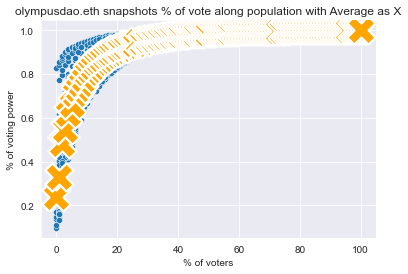

In [39]:
plt.rc("figure", figsize=(40, 20))
#sns.set_style("whitegrid")
plt.rc("font", size=25)
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()
##print(data_means)
plot_title = spacename + ' snapshots % of vote along population with Average as X'

ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped").set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
chart = sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=800,marker='X',color = 'orange')
#and save the chart file, too
plt.savefig(final_file+'\\'+spacename+' vote power distribution.png',transparent =False,  dpi=100)

means_data_path =final_file+'\\'+spacename+'_means_'+'.csv'
data_means.to_csv(means_data_path, index = False)

print(chart)
data_means

The chart above shows what % of all possible votes has been cast (Y axis) as each incremental percent of the voting population casts their vote (X axis). Each line is a Proposal and has a unique color, so that a dot on each percent point represents what % of total voting power was accumulated by that group. The color represents which vote was cast.
The Orange X shows the average % of power accumulated across all elections.

AxesSubplot(0.125,0.125;0.775x0.755)


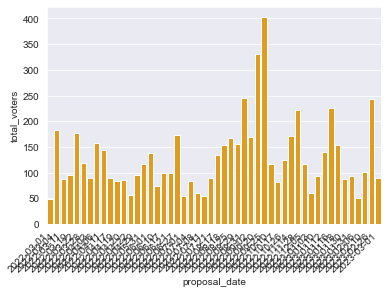

In [40]:
voters_df = db.query("select  proposals_title, count(distinct votes_voter) total_voters,  min(proposal_date) proposal_date from crunch_data group by 1 order by 1 asc").df()

chart = sns.barplot(data=voters_df,x="proposal_date",y="total_voters", color = 'orange', ci=None)
x_dates = voters_df['proposal_date'].dt.strftime('%Y-%m-%d').sort_values().unique()
chart.set_xticklabels(labels=x_dates, rotation=45, ha='right')
#and save the chart file, too

print(chart)

#and save the chart file, too
plt.savefig(final_file+'\\'+spacename+'_proposal_participation.png',transparent =False,  dpi=100)


AxesSubplot(0.125,0.125;0.775x0.755)


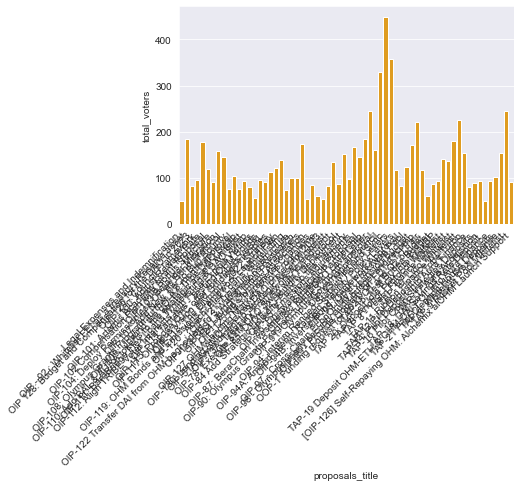

In [41]:
voters_df = db.query("select  proposals_title, count(distinct votes_voter) total_voters,  min(proposal_date) proposal_date from crunch_data group by 1 order by 1 asc").df()

chart = sns.barplot(data=voters_df,x="proposals_title",y="total_voters", color = 'orange')
proposal_titles =  voters_df['proposals_title'].sort_values().unique()
chart.set_xticklabels(labels=proposal_titles, rotation=45, ha='right')
#and save the chart file, too

print(chart)
plt.savefig(final_file+'\\'+spacename+'_proposal_participation_title.png',transparent =False,  dpi=100)

means_data_path =final_file+'\\'+spacename+'proposal voters'+'.csv'
voters_df.to_csv(means_data_path, index = False)


In [42]:
p50 = db.query("select min(percentage_voters_counted) "
               "from data_means  where cum_percentage_of_total_vp>=0.5 ").df()
p50display = round(100*(p50.iloc[0,0]),2)
print('On average, a proposal at ', spacename, 'takes ',p50display,'% of the voting population.')

print('A total of ',leader_count, 'wallets have driven the result of all proposals at',spacename,)
print('That\'s', ("{0:.2%}".format(elite)), 'of all DAO voters.')

On average, a proposal at  olympusdao.eth takes  3.04 % of the voting population.
A total of  75 wallets have driven the result of all proposals at olympusdao.eth
That's 3.72% of all DAO voters.


In [43]:
crunch_data.head(10)

,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,proposal_date_2,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x3F435ecb51C986CD2942c700e1E5076050D1Bb62,1,8410.354331,1646356214,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-04 01:10:14,8410.354331,53521.054419,0.157141,0.157141,0.0,1,1,0.006494,1.0
1,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8165.904205,1646233183,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-02 14:59:43,16576.258536,53521.054419,0.152574,0.309715,0.0,2,2,0.012987,1.0
2,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8165.904205,1646233293,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 15:01:33,8165.904205,43300.813626,0.188585,0.188585,0.0,1,1,0.006579,1.0
3,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1646377484,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-04 07:04:44,11478.629586,43300.813626,0.076505,0.265090,0.0,2,2,0.013158,1.0
4,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1646377527,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-04 07:05:27,19888.983917,53521.054419,0.061896,0.371610,0.0,3,3,0.019481,2.0
5,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0xeAbed8538923d8B8E0616938F8Dc657F3CDF74c6,1,3272.832615,1646232431,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 14:47:11,14751.462201,43300.813626,0.075584,0.340674,0.0,3,3,0.019737,2.0
6,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0xeAbed8538923d8B8E0616938F8Dc657F3CDF74c6,1,3272.832615,1646232480,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-02 14:48:00,23161.816532,53521.054419,0.061150,0.432761,0.0,4,4,0.025974,3.0
7,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x6716b6737620922ACC8F8B8A4c2A6D706F3224FF,1,2791.835058,1646285764,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-03 05:36:04,17543.297259,43300.813626,0.064475,0.405149,0.0,4,4,0.026316,3.0
8,olympusdao.eth,0xece47fbf9e8f9fe362ed3a7cc0bc11705ad2de5c4baa...,0x6716b6737620922ACC8F8B8A4c2A6D706F3224FF,1,2791.835058,1646285798,TAP-6: Whitelist Frax Finance,2022-03-01,2022-03-03 05:36:38,25953.651590,53521.054419,0.052163,0.484924,0.0,5,5,0.032468,3.0
9,olympusdao.eth,0x7d65f346d0285a10457c1f61fbfad1b2337c55e29114...,0x5bef46ac7f33b5E2FC2b6F26628884e7163eE96C,1,1850.886650,1646250915,OIP-83: Curve v2 Liquidity Deployment,2022-03-01,2022-03-02 19:55:15,19394.183910,43300.813626,0.042745,0.447894,0.0,5,5,0.032895,3.0


In [44]:
plt.rc("figure", figsize=(40, 20))
sns.set_style("whitegrid")
plt.rc("font", size=25)
plot_title = spacename + 'Voting power dist'

#ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped").set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
#chart = sns.distplot(crunch_data['votes_vp'], hist=True, kde=True,             bins=10,             color = 'darkblue',             hist_kws={'edgecolor':'black'},             kde_kws={'linewidth': 4})

chart =sns.histplot(
    diamonds,
    x="price", hue="cut",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)


#
#chart = sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=600,marker='X',color = 'orange')
#and save the chart file, too
#plt.savefig(final_file+'\\'+spacename+' vote power distribution.png', dpi=100)

#means_data_path =final_file+'\\'+spacename+'_means_'+'.csv'
#data_means.to_csv(means_data_path, index = False)

print(chart)

NameError: name 'diamonds' is not defined